In [9]:
# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import copy
import shap
import lightgbm as lgb
import sklearn.preprocessing 
import sklearn.feature_selection
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats.stats import spearmanr, pearsonr
import joblib

In [13]:
#Random seed
SEED = np.random.seed(2020)

In [15]:
############ Data Processing ###########
print("\n...... Processing Data ......\n")

#Load data
GTEx = pd.read_csv('/home/lilabguest2/shenhaoyu/GTEx_feature_river',sep = '\t',index_col=0)
GTEx=GTEx.iloc[:,:-1]
GTEx


...... Processing Data ......



,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,TFBS,...,frameshift,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair
SubjectID,,,,,,,,,,,,,,,,,,,,,
GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,-0.19737,...,0,0,0,0,0,1,1,-0.032098,0.133035,NaN
GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,-0.19737,...,0,0,0,0,0,0,1,-0.039549,0.180873,NaN
GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,-0.19737,...,0,0,0,0,0,1,1,-0.043518,0.266312,4.0
GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,0.21474,...,0,0,0,0,0,1,1,-0.035048,-0.051501,NaN
GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,-0.19737,...,0,0,0,0,0,1,1,-0.045419,-0.566845,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,-0.19737,...,0,0,0,0,0,1,1,-0.035131,0.249869,NaN
GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,-0.19737,...,0,0,0,0,0,1,1,-0.035131,-0.037060,NaN
GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,-0.19737,...,0,0,0,0,0,1,1,-0.040535,-0.583484,NaN


In [17]:
GTEx['out']=GTEx['Zscore'].apply(lambda x : 1 if x >=2 else -1 if x<=-2 else 0 )
GTEx

,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,TFBS,...,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair,out
SubjectID,,,,,,,,,,,,,,,,,,,,,
GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,-0.19737,...,0,0,0,0,1,1,-0.032098,0.133035,NaN,0
GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,-0.19737,...,0,0,0,0,0,1,-0.039549,0.180873,NaN,0
GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,-0.19737,...,0,0,0,0,1,1,-0.043518,0.266312,4.0,0
GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,0.21474,...,0,0,0,0,1,1,-0.035048,-0.051501,NaN,0
GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,-0.19737,...,0,0,0,0,1,1,-0.045419,-0.566845,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,-0.19737,...,0,0,0,0,1,1,-0.035131,0.249869,NaN,0
GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,-0.19737,...,0,0,0,0,1,1,-0.035131,-0.037060,NaN,0
GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,-0.19737,...,0,0,0,0,1,1,-0.040535,-0.583484,NaN,0


In [18]:
GTEx['out'].value_counts()

 0    3857023
 1       2934
-1       2086
Name: out, dtype: int64

In [19]:
GTEx_over=GTEx[GTEx['out']==1]
GTEx_over

,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,TFBS,...,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair,out
SubjectID,,,,,,,,,,,,,,,,,,,,,
GTEX-14E6C,ENSG00000003436.10,-0.464771,0.545497,-0.397834,-0.031157,0.994042,-7.040885,-1.242086,0.225990,-0.197370,...,0,0,0,0,1,1,-0.027566,2.134094,NaN,1
GTEX-ZTTD,ENSG00000004478.5,0.042709,-0.503801,-0.096654,-0.322530,-0.030784,0.041967,-0.896113,0.065765,-0.197370,...,0,0,0,0,1,1,-0.024064,2.154996,NaN,1
GTEX-15UKP,ENSG00000004534.10,-0.211031,-0.766125,0.177461,-0.677034,-1.527253,0.188745,-0.854767,0.107563,-0.197370,...,0,0,0,0,1,1,-0.044208,2.185644,NaN,1
GTEX-13G51,ENSG00000004660.10,2.495533,4.218041,-0.397834,-0.268418,-1.208076,-7.040885,-1.242086,0.225990,-0.197370,...,0,0,0,0,1,1,-0.044299,2.089707,NaN,1
GTEX-YEC3,ENSG00000005243.5,2.072633,4.480366,0.847283,2.337521,0.705104,0.823460,0.758353,1.021617,0.008685,...,0,0,1,0,1,1,0.235661,2.169942,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-12ZZZ,ENSG00000231360.2,2.580113,6.054313,-0.642941,2.575707,1.483620,1.538958,-0.153701,0.882291,0.420796,...,0,0,0,0,1,1,-0.047620,3.360837,366693.0,1
GTEX-147GR,ENSG00000231360.2,-3.002175,-0.766125,-0.986612,-1.019976,-2.313917,0.203891,-1.242086,-4.283787,-0.197370,...,0,0,0,0,1,0,-0.047636,3.370429,NaN,1
GTEX-REY6,ENSG00000231360.2,2.580113,6.054313,-0.642941,2.575707,1.483620,1.538958,-0.153701,0.882291,0.420796,...,0,0,0,0,1,1,-0.047620,2.293286,366693.0,1


In [20]:
GTEx_under=GTEx[GTEx['out']==-1]
GTEx_under

,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,TFBS,...,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair,out
SubjectID,,,,,,,,,,,,,,,,,,,,,
GTEX-111YS,ENSG00000001461.12,0.550190,-0.503801,-0.014524,-0.307731,0.160735,0.481219,1.360309,1.098614,-0.19737,...,0,0,0,0,1,1,-0.040674,-3.508156,NaN,-1
GTEX-15UF7,ENSG00000003509.11,-0.633932,0.020848,0.813832,0.817756,0.767738,0.220480,0.241522,0.257045,-0.19737,...,0,0,0,0,1,1,-0.042394,-2.425746,NaN,-1
GTEX-1B996,ENSG00000003756.12,0.042709,0.545497,1.835257,0.061111,0.780348,-0.066584,-0.208424,-0.598969,-0.19737,...,0,0,0,0,1,1,-0.041589,-2.029885,NaN,-1
GTEX-Y8LW,ENSG00000004864.9,0.634770,1.070147,0.813832,2.957267,1.688855,1.147670,1.992666,2.176560,-0.19737,...,1,0,0,0,1,1,-0.027560,-2.723114,NaN,-1
GTEX-1A3MV,ENSG00000005700.10,-0.549351,-0.503801,6.947333,8.460982,1.817598,2.337763,2.442613,2.121563,-0.19737,...,0,1,0,0,1,1,-0.043352,-3.730508,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-17EUY,ENSG00000184227.3,-0.295611,0.020848,-0.124970,0.776131,1.392701,0.133207,0.411772,0.298953,-0.19737,...,0,0,0,0,1,1,-0.026518,-2.022617,NaN,-1
GTEX-17JCI,ENSG00000235999.1,-3.002175,-0.766125,-0.986612,-1.019976,-2.313917,0.338408,-1.242086,-4.283787,-0.19737,...,0,0,0,0,1,0,-0.028444,-2.103976,NaN,-1
GTEX-17EVQ,ENSG00000204790.8,-0.633932,-0.503801,-0.167308,-0.671947,-0.291941,-0.180184,-0.944148,0.405648,-0.19737,...,0,0,0,0,1,1,-0.044564,-4.016659,366881.0,-1


# 1.overexpression indentified

In [ ]:
#Control samples
GTEx_ctr = GTEx[GTEx["out"] == 0] 
GTEx_ctr = GTEx_ctr.sample(len(GTEx_over),random_state = SEED) 
#Concat case and partial control
GTEx_dataset_oi = pd.concat([GTEx_over,GTEx_ctr]) 
GTEx_dataset_oi

In [ ]:
GTEx_feature_oi=GTEx_dataset_oi.drop(['Zscore','N2pair','out','upstream_downstream10kb_200kb','GeneName'],axis=1)
GTEx_feature_oi

In [15]:
out=GTEx_dataset_oi['out']
out

SubjectID
GTEX-14E6C    1
GTEX-ZTTD     1
GTEX-15UKP    1
GTEX-13G51    1
GTEX-YEC3     1
             ..
GTEX-P78B     0
GTEX-O5YV     0
GTEX-15SB6    0
GTEX-13D11    0
GTEX-12584    0
Name: out, Length: 5868, dtype: int64

In [16]:
#Input
X = copy.deepcopy(GTEx_feature_oi)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
#拷贝一份用于输入
#TrainingSet : TestSet = 4 : 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################


...... Finished Data Processing ......



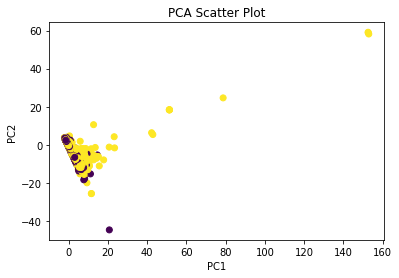

In [18]:
#PCA二维可视化
from sklearn.decomposition import PCA
X_train_pca=PCA(n_components=2).fit_transform(X_train)
# 根据主成分分析结果绘制散点图
plt.scatter(X_train_pca[:,0],X_train_pca[:,1] ,c=y_train)
# 设置坐标标签
plt.xlabel('PC1')
plt.ylabel('PC2')
# 设置标题
plt.title("PCA Scatter Plot")
# 显示图形
plt.show()

In [19]:
########## Model Construction ##########
print("\n...... Training Model ......\n")

# LightGBM params
param_dict = {
    "learning_rate":[0.1, 0.05, 0.02, 0.015, 0.01],#学习率
    "num_leaves": range(10,36,5),# Maximum tree leaves for base learners.
    "max_depth" : [-1,2,3,4,5,10,20,40,50],#Maximum tree depth for base learners, <=0 means no limit.
    "min_data_in_leaf": range(1, 45, 2),#
    "feature_fraction" : [i / 10 for i in range(2,11)],#
    "metric" : ["binary_logloss"],#
    "early_stopping_rounds" : [None],#
    "n_jobs" : [-1],#
    "silent" : [True],#
    "verbose" : [-1],#
    "n_estimators" : range(50,1000,50),#
    "bagging_fraction" :  [i / 10 for i in range(2, 11)],#
    "bagging_freq" : [0, 1, 2],#
    "lambda_l1" : [0, 0.001, 0.005, 0.01, 0.1],#
    "lambda_l2" : [0, 0.001, 0.005, 0.01, 0.1],#
    "objective":["binary"],#
    "random_state":[2020]#
}#参数列表

#Initiate model
model = lgb.LGBMClassifier()#创建一个分类器对象


...... Training Model ......



In [20]:
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          n_iter=100,# Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型   

Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


In [21]:
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)


...... Evaluating Model ......

[1 1 0 ... 0 0 1]


array([0.84545511, 0.81977583, 0.3448878 , ..., 0.13585717, 0.33662724,
       0.5247997 ])

In [30]:
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 8),n_jobs=5,scoring='neg_mean_squared_error')#(.1, 1.0, 5)设步长，0.1开始到1，分五份

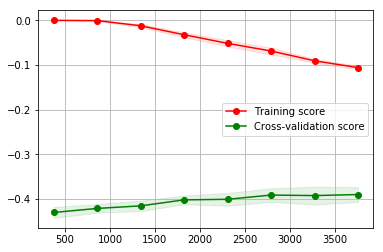

In [31]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


In [23]:
#Evaluate performance of model
#返回auroc/auroc_curve、auprc/auprc_curve、accuracy、recall、precision、f1、class_report
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 

    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [24]:
# Output result of evaluation
#生成文件可以用于作图（bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc ）
def eval_output(model_perf,output_file):
    with open(output_file,'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [25]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"


In [26]:
# Plot AUROC of model
def plot_AUROC(model_perf,output_file):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) #%相当于format方法,格式化输出,替换%***
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")

In [27]:
# Plot AUPRC of model
def plot_AUPRC(model_perf,output_file):
    #get AUPRC,Precision,Recall and threshold
    prc_auc = model_perf["auprc"]
    precision,recall,threshold = model_perf["auprc_curve"]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))#设置figure的宽、长
    plt.plot(recall, precision, color="red",
             lw=lw,#折线图的线条宽度
             label='AUPRC (area = %0.2f)' % prc_auc#图例
            ) 
    plt.plot([0, 1], [1, 0], color="navy", lw=lw, linestyle='--')#对角线
    #设置x、y坐标轴的范围
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    #坐标轴标签
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("AUPRC of Models")
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

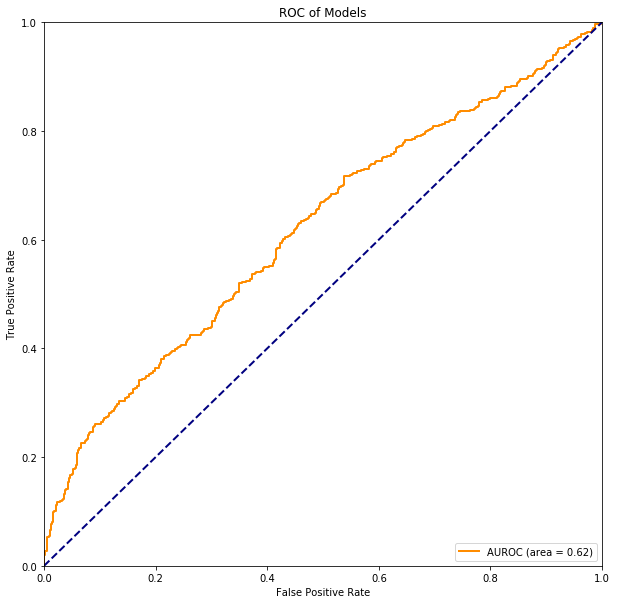

<Figure size 432x288 with 0 Axes>

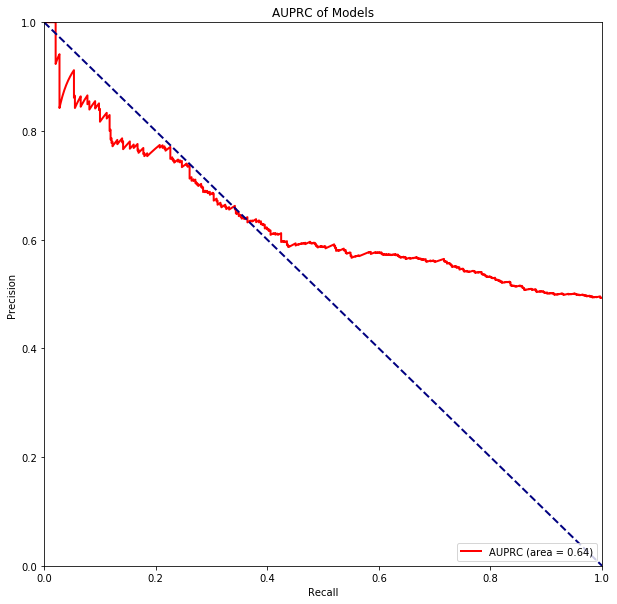

In [28]:
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################


...... Interpreting Model ......



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



This is an overview of which features are most important(top 10) represented by SHAP values of every feature for every sample



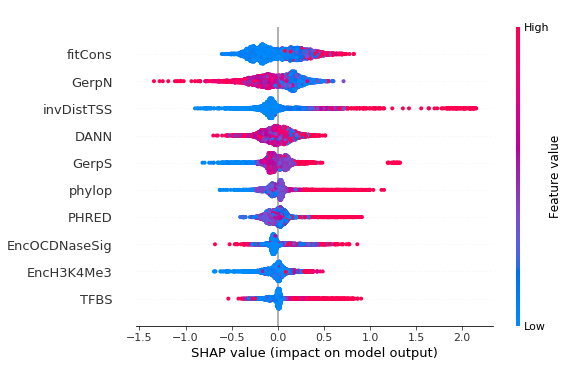


This is an overview of which features are most important(top 10) represented by  mean absolute value of the SHAP values for each feature



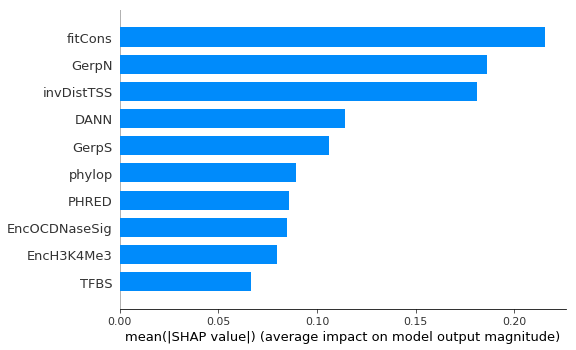

In [32]:
######## Model Interpretation ########

print("\n...... Interpreting Model ......\n")

# load JS visualization code to notebook
shap.initjs()
#Explain the model's predictions on the entire dataset for cancer case
explainer = shap.TreeExplainer(rscv.best_estimator_) # 初始化解释器
explainer.shap_values(X)#计算每个样本的每个特征的SHAP值
#给定当前的一组特征值，特征值对实际预测值与平均预测值之差的贡献就是估计的Shap值
shap_values = explainer.shap_values(X)[1]
shap_values#每个列表为一个样本
#Plot the SHAP values of every feature(top 10) for every sample
print("\nThis is an overview of which features are most important(top 10) represented by \
SHAP values of every feature for every sample\n")
shap.summary_plot(shap_values, X,max_display = 10)
#把所有的样本点都呈现在图中
#如图，此时颜色代表特征值的大小，而横坐标为shap值的大小
#从图中可以看到fitCons这一特征，值越大，shap值越大，换句话来说就是fitCons越小，风险越高。
#Plot the mean absolute value of the SHAP values for each feature(top 10)
print("\nThis is an overview of which features are most important(top 10) represented by \
 mean absolute value of the SHAP values for each feature\n")
shap.summary_plot(shap_values, X,plot_type="bar",max_display = 10)
#该图是对全部样本全部特征的shaple值进行求和，可以反映出特征重要性及每个特征对样本正负预测的贡献。
#If you want to save shap plot as pdf,just modify the following code
#fig = shap.summary_plot(shap_values, X, show=False,max_display = 10)
#plt.savefig("shap.pdf", format='pdf', dpi=1000, bbox_inches='tight')


# 1.underexpression indentified

In [21]:
#Control samples
GTEx_ctr = GTEx[GTEx["out"] == 0] 
GTEx_ctr = GTEx_ctr.sample(len(GTEx_under),random_state = SEED) 
#Concat case and partial control
GTEx_dataset_ui = pd.concat([GTEx_under,GTEx_ctr]) 
GTEx_feature_ui=GTEx_dataset_ui.drop(['Zscore','N2pair','out','upstream_downstream10kb_200kb','GeneName'],axis=1)
out=GTEx_dataset_ui['out'].apply(lambda x : 1 if x==-1 else 0)
#Input
X = copy.deepcopy(GTEx_feature_ui)#经过deepcopy的操作的不管是内层还是外层数据对象都拥有不同的地址空间，修改其中的值不会对两个对象都造成影响
y = copy.deepcopy(out)
#拷贝一份用于输入
#TrainingSet : TestSet = 4 : 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)
print("\n...... Finished Data Processing ......\n")
########################################


...... Finished Data Processing ......



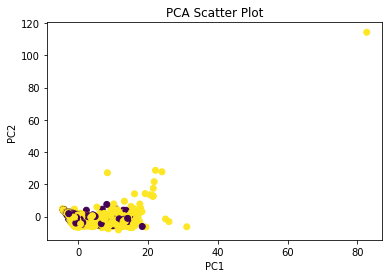

In [40]:
#PCA二维可视化
from sklearn.decomposition import PCA
X_train_pca=PCA(n_components=2).fit_transform(X_train)
# 根据主成分分析结果绘制散点图
plt.scatter(X_train_pca[:,0],X_train_pca[:,1] ,c=y_train)
# 设置坐标标签
plt.xlabel('PC1')
plt.ylabel('PC2')
# 设置标题
plt.title("PCA Scatter Plot")
# 显示图形
plt.show()

In [22]:
########## Model Construction ##########
print("\n...... Training Model ......\n")

# LightGBM params
param_dict = {
    "learning_rate":[0.1, 0.05, 0.02, 0.015, 0.01],#学习率
    "num_leaves": range(10,36,5),# Maximum tree leaves for base learners.
    "max_depth" : [-1,2,3,4,5,10,20,40,50],#Maximum tree depth for base learners, <=0 means no limit.
    "min_data_in_leaf": range(1, 45, 2),#
    "feature_fraction" : [i / 10 for i in range(2,11)],#
    "metric" : ["binary_logloss"],#
    "early_stopping_rounds" : [None],#
    "n_jobs" : [-1],#
    "silent" : [True],#
    "verbose" : [-1],#
    "n_estimators" : range(50,1000,50),#
    "bagging_fraction" :  [i / 10 for i in range(2, 11)],#
    "bagging_freq" : [0, 1, 2],#
    "lambda_l1" : [0, 0.001, 0.005, 0.01, 0.1],#
    "lambda_l2" : [0, 0.001, 0.005, 0.01, 0.1],#
    "objective":["binary"],#
    "random_state":[2020]#
}#参数列表

#Initiate model
model = lgb.LGBMClassifier()#创建一个分类器对象


...... Training Model ......



In [23]:
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model,#
                          param_dict,#
                          n_iter=100,# Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.
                          cv = 5,# Determines the cross-validation splitting strategy.
                          verbose = 0,# Controls the verbosity: the higher, the more messages.
                          scoring = "roc_auc",#
                          n_jobs =-1#
                         )#用分类器对象创建一个RandomizedSearchCV的对象
gbm=rscv.fit(X_train, y_train)#得到训练后的模型   

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [24]:
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
print(y_pred)
y_prob = best_model.predict_proba(X_test)[:,1]
y_prob#probability of prediction as positive,len:40(test set)


...... Evaluating Model ......

[0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0
 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0
 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1
 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1
 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1
 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1
 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 

array([0.23639381, 0.96834714, 0.24673082, 0.30712463, 0.38415758,
       0.36665837, 0.28488542, 0.26886323, 0.35800025, 0.95557178,
       0.46227739, 0.33224099, 0.32776907, 0.72012876, 0.942385  ,
       0.2847022 , 0.96115328, 0.34992976, 0.41150378, 0.37325579,
       0.33162046, 0.36498205, 0.22699241, 0.88902366, 0.24264881,
       0.30789407, 0.24980207, 0.22409391, 0.967804  , 0.2641116 ,
       0.35453825, 0.94968865, 0.79097024, 0.42790911, 0.25462142,
       0.67079157, 0.26059158, 0.89965782, 0.29169688, 0.29531416,
       0.95318897, 0.32049221, 0.43364425, 0.38571721, 0.96513408,
       0.54377862, 0.24304369, 0.44087931, 0.32382448, 0.29710884,
       0.37643606, 0.93480466, 0.90153014, 0.87785145, 0.9529132 ,
       0.38824095, 0.96585429, 0.40177031, 0.94837887, 0.25338535,
       0.28494578, 0.13921598, 0.29684057, 0.58292024, 0.5003725 ,
       0.92679443, 0.72554981, 0.657654  , 0.3264579 , 0.7550877 ,
       0.41642876, 0.19851681, 0.31332465, 0.30272985, 0.20262

In [44]:
#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,"./Evaluate_Result_TestSet.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"



...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

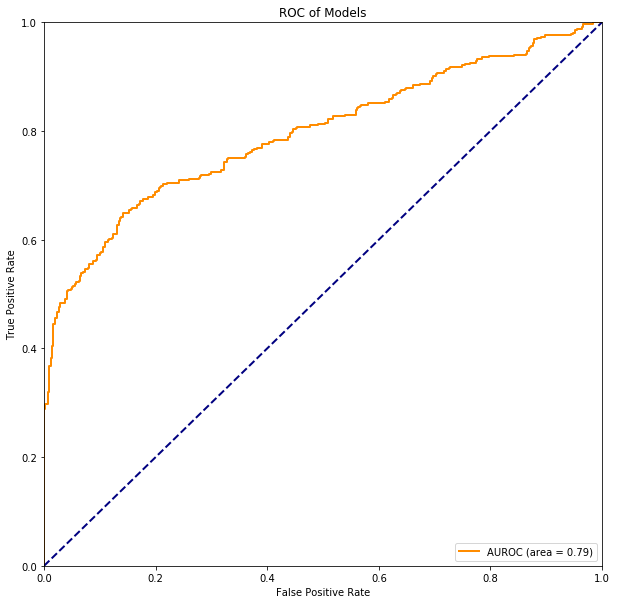

<Figure size 432x288 with 0 Axes>

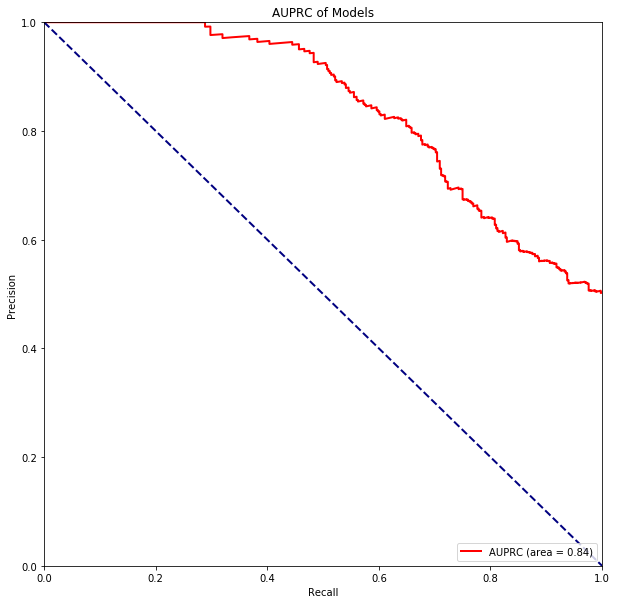

In [45]:
#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"./AUROC_TestSet.pdf")
plot_AUPRC(model_perf,"./AUPRC_TestSet.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

In [46]:
#绘制学习曲线
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, CV_scores=learning_curve(best_model,X_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 8),n_jobs=10,scoring='neg_mean_squared_error')#(.1, 1.0, 5)设步长，0.1开始到1，分五份

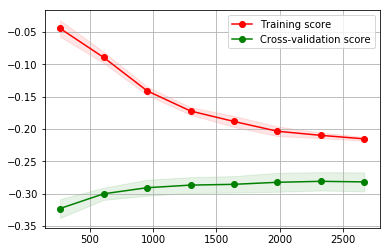

In [47]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
CV_scores_mean = np.mean(CV_scores, axis=1)
CV_scores_std = np.std(CV_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, CV_scores_mean - CV_scores_std,
                     CV_scores_mean + CV_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, CV_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")


...... Interpreting Model ......




This is an overview of which features are most important(top 10) represented by SHAP values of every feature for every sample



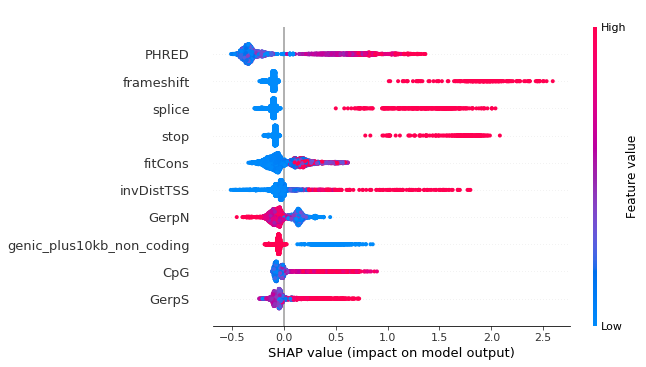


This is an overview of which features are most important(top 10) represented by  mean absolute value of the SHAP values for each feature



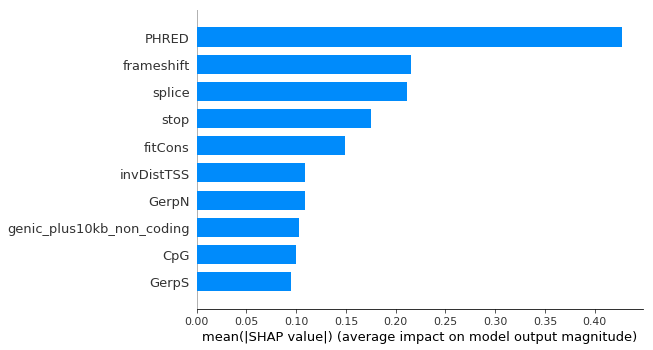

In [25]:
######## Model Interpretation ########

print("\n...... Interpreting Model ......\n")

# load JS visualization code to notebook
shap.initjs()
#Explain the model's predictions on the entire dataset for cancer case
explainer = shap.TreeExplainer(rscv.best_estimator_) # 初始化解释器
explainer.shap_values(X)#计算每个样本的每个特征的SHAP值
#给定当前的一组特征值，特征值对实际预测值与平均预测值之差的贡献就是估计的Shap值
shap_values = explainer.shap_values(X)[1]
shap_values#每个列表为一个样本
#Plot the SHAP values of every feature(top 10) for every sample
print("\nThis is an overview of which features are most important(top 10) represented by \
SHAP values of every feature for every sample\n")
shap.summary_plot(shap_values, X,max_display = 10)
#把所有的样本点都呈现在图中
#如图，此时颜色代表特征值的大小，而横坐标为shap值的大小
#从图中可以看到fitCons这一特征，值越大，shap值越大，换句话来说就是fitCons越小，风险越高。
#Plot the mean absolute value of the SHAP values for each feature(top 10)
print("\nThis is an overview of which features are most important(top 10) represented by \
 mean absolute value of the SHAP values for each feature\n")
shap.summary_plot(shap_values, X,plot_type="bar",max_display = 10)
#该图是对全部样本全部特征的shaple值进行求和，可以反映出特征重要性及每个特征对样本正负预测的贡献。
#If you want to save shap plot as pdf,just modify the following code
#fig = shap.summary_plot(shap_values, X, show=False,max_display = 10)
#plt.savefig("shap.pdf", format='pdf', dpi=1000, bbox_inches='tight')



This is a heatmap for shap interaction values of most important(top 10) features



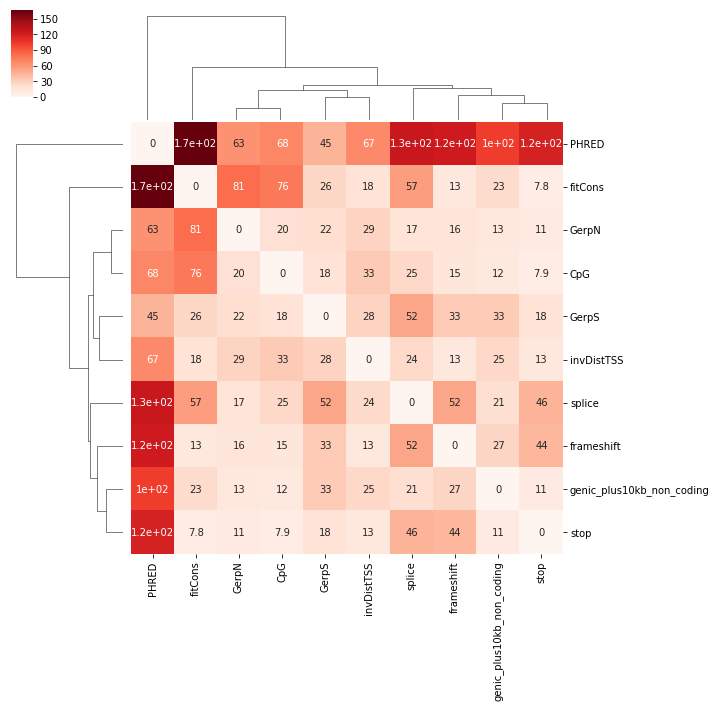

In [28]:
#Get shap interaction values
shap_interaction_values = explainer.shap_interaction_values(X)
#Plot heatmap of shap interaction values
print("\nThis is a heatmap for shap interaction values of most important(top 10) features\n")
tmp = np.abs(shap_interaction_values).sum(0)#.sum(0)按列相加
tmp#shape:30*30
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:10]#.argsort数组值从小到大的索引值（取负求和后实际最终获得从大到小）
tmp2 = tmp[inds,:][:,inds]
#seaborn style
sn.clustermap(tmp2,annot=True,cmap= "Reds" ,square=True,figsize=(10,10),xticklabels=X.columns[inds],yticklabels=X.columns[inds]
          )#


#########Two instances of shap interaction are the following########


First instance: PHRED and splice



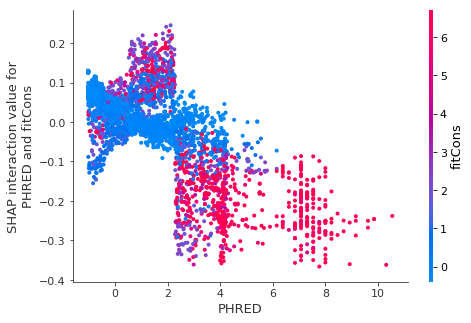

In [31]:
#Instances of shap interaction
print("\n#########Two instances of shap interaction are the following########\n")

print("\nFirst instance: PHRED and splice\n")
#fitcon and invdistss
#shap main effect of Testosterone
shap.dependence_plot(
    ("PHRED", "fitCons"),
    shap_interaction_values, X,
    display_features=X
)
#SHAP依赖图


#########Two instances of shap interaction are the following########


First instance: PHRED and frameshift



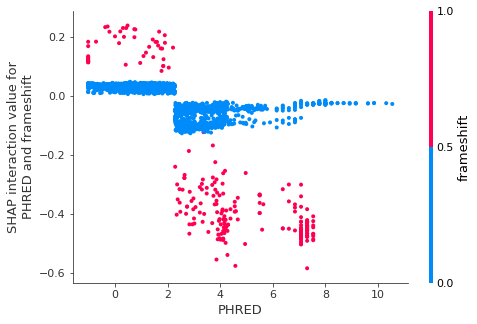

In [34]:
#Instances of shap interaction
print("\n#########Two instances of shap interaction are the following########\n")

print("\nFirst instance: PHRED and frameshift\n")
#fitcon and invdistss
#shap main effect of Testosterone
shap.dependence_plot(
    ("PHRED", "frameshift"),
    shap_interaction_values, X,
    display_features=X
)
#SHAP依赖图


#########Two instances of shap interaction are the following########


First instance: PHRED and splice



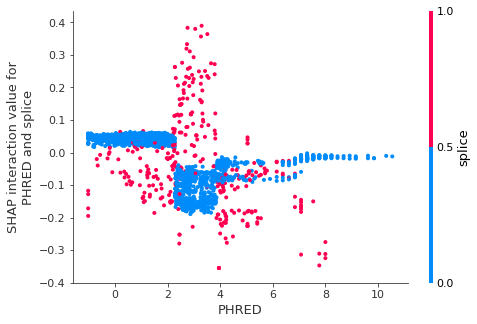

In [36]:
#Instances of shap interaction
print("\n#########Two instances of shap interaction are the following########\n")

print("\nFirst instance: PHRED and splice\n")
#fitcon and invdistss
#shap main effect of Testosterone
shap.dependence_plot(
    ("PHRED", "splice"),
    shap_interaction_values, X,
    display_features=X
)
#SHAP依赖图


#########Two instances of shap interaction are the following########


First instance: PHRED and stop



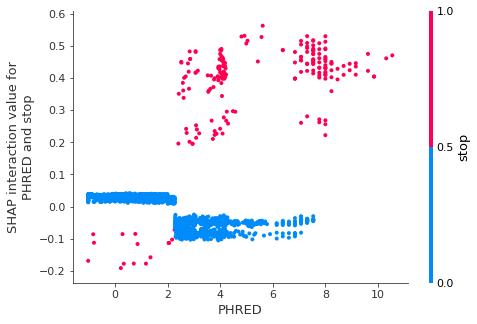

In [37]:
#Instances of shap interaction
print("\n#########Two instances of shap interaction are the following########\n")

print("\nFirst instance: PHRED and stop\n")
#fitcon and invdistss
#shap main effect of Testosterone
shap.dependence_plot(
    ("PHRED", "stop"),
    shap_interaction_values, X,
    display_features=X
)
#SHAP依赖图


#########Two instances of shap interaction are the following########


First instance: PHRED and GerpN



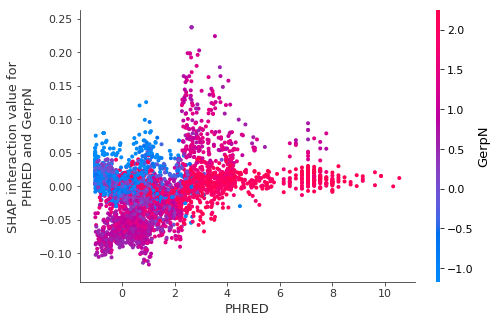

In [35]:
#Instances of shap interaction
print("\n#########Two instances of shap interaction are the following########\n")

print("\nFirst instance: PHRED and GerpN\n")
#fitcon and invdistss
#shap main effect of Testosterone
shap.dependence_plot(
    ("PHRED", "GerpN"),
    shap_interaction_values, X,
    display_features=X
)
#SHAP依赖图

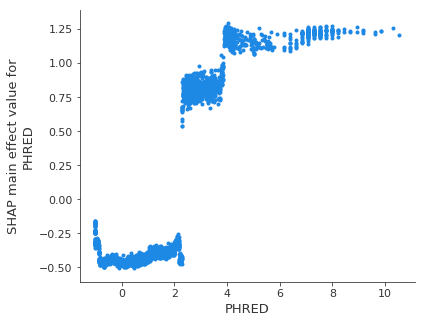

In [38]:
shap.dependence_plot( ("PHRED", "PHRED"), shap_interaction_values, X, display_features=X ) 